# 학습 마친 모델을 실전 투입하기

## 이번 실습의 목표
- 학습을 마친 문서 분류 모델을 가지고 웹 서비스(web service)를 구현
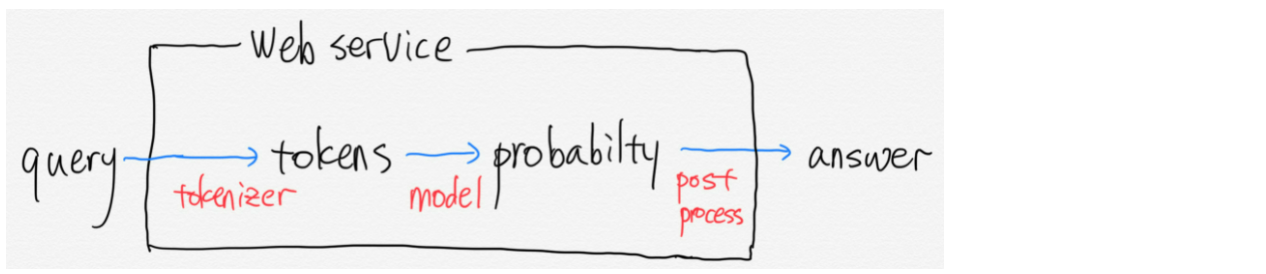
- 문장을 받아 해당 문장이 긍정인지 부정인지 답변하는 웹 서비스
- 문장을 토큰화한 뒤 모델 입력값으로 만들고 이를 모델에 태워 [해당 문장이 긍정일 확률, 해당 문장이 부정일 확률]을 계산

## 실습환경 구성
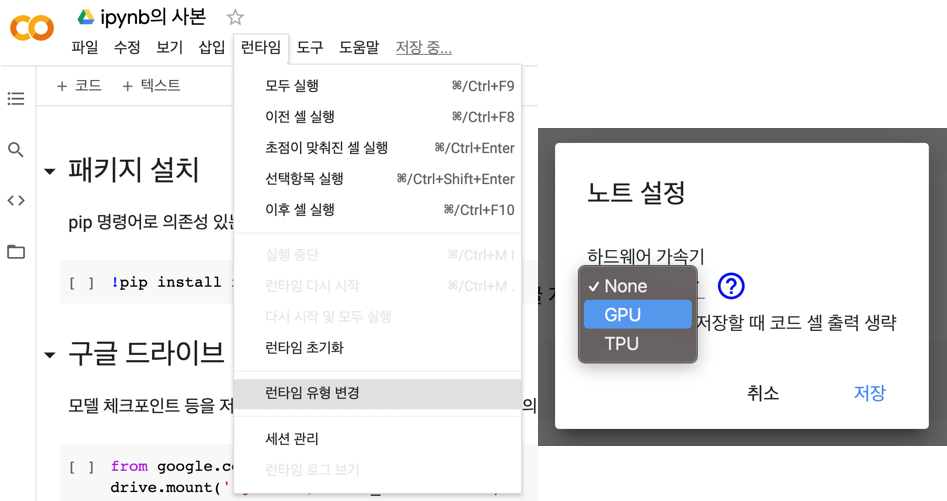

코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

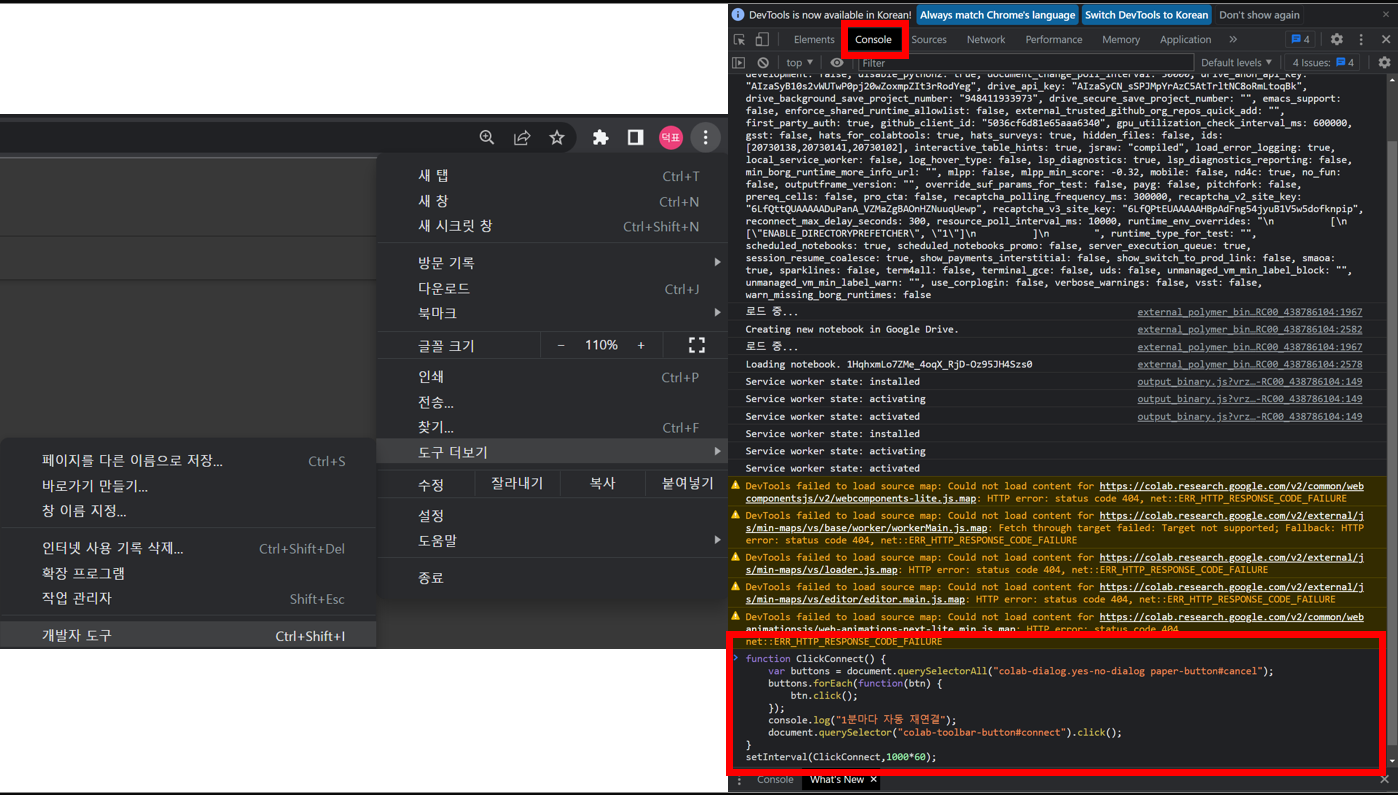

## 추가 라이브러리 설치

In [1]:
!pip install ratsnlp

     |████████████████████████████████| 42 kB 634 kB/s 
     |████████████████████████████████| 2.8 MB 10.4 MB/s 
     |████████████████████████████████| 806 kB 37.4 MB/s 
     |████████████████████████████████| 57 kB 4.6 MB/s 
     |████████████████████████████████| 829 kB 40.7 MB/s 
     |████████████████████████████████| 636 kB 41.4 MB/s 
     |████████████████████████████████| 398 kB 69.4 MB/s 
     |████████████████████████████████| 136 kB 59.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 43.3 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |████████████████████████████████| 96 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 64.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sh

### 구글드라이브 연동

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 학습된 데이터 다운로드

In [ ]:
!pip install -U --no-cache-dir gdown --pre
print("Downloading...")
!gdown --id {"1-8qVjrKzUwj4uh-yM6H4_BiTUY125JEU"} -O /content/drive/MyDrive/nlpbook/checkpoint-doccls/epoch=0-val_loss=0.27.ckpt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=ace827e5ece19804ec821d2960ba715555175de34802742a8b61f6da5980ddbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-xwdxbt2u/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
Downloading...
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-X2MootamlEu_9DMWVwI3ExenoHjrG-Z
To: /content/drive/MyDrive/nlpbook/checkpoint-doccls/epoch=0-val_loss=0.27-v1.ckpt
100% 1.30G/1.30G [0

### 인퍼런스 설정

In [3]:
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/content/drive/MyDrive/nlpbook/checkpoint-doccls",
    max_seq_length=128,
)

downstream_model_checkpoint_fpath: /content/drive/MyDrive/nlpbook/checkpoint-doccls/epoch=0-val_loss=0.27.ckpt


```
pretrained_model_name : 이전 장에서 파인튜닝한 모델이 사용한 프리트레인 마친 언어모델 이름
downstream_model_dir : 이전 장에서 파인튜닝한 모델의 체크포인트 저장 위치.
max_seq_length : 토큰 기준 입력 문장 최대 길이. 아무 것도 입력하지 않으면 128
```

## 토크나이저 및 모델 불러오기

### 토크나이저 로드

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    "beomi/kcbert-base",
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

### 체크포인트 로드

In [5]:
import torch
fine_tuned_model_ckpt = torch.load(
    '/content/drive/MyDrive/nlpbook/checkpoint-doccls/epoch=0-val_loss=0.27.ckpt',
    map_location=torch.device("cpu")
)

### BERT 설정 로드
- 이전 장에서 파인튜닝한 모델이 사용한 프리트레인 마친 언어모델의 설정 값들을 읽음.

In [6]:
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(
    "beomi/kcbert-base",
    num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel(),
)

### BERT 모델 초기화

In [7]:
model = BertForSequenceClassification(pretrained_model_config)

### 체크포인트 읽기
- 초기화한 BERT 모델에 코드5의 `fine_tuned_model_ckpt`를 읽는다.

In [8]:
model.load_state_dict({k.replace("model.", ""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

<All keys matched successfully>

### 평가 모드 전환
- 모델이 평가 모드로 전환
- 드롭아웃 등 학습 때만 사용하는 기법들을 무효화하는 역할

In [9]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 모델 출력값 만들고 후처리
- 문장(sentence)에 토큰화를 수행한 뒤 `input_ids`, `attention_mask`, `token_type_ids`를 만든 후 입력값을 파이토치 텐서(tensor) 자료형으로 변환한 뒤 모델에 입력.
- 모델 출력 값(outputs.logits)은 소프트맥스 함수 적용 이전의 로짓(logit) 형태, 여기에 소프트맥스 함수를 써서 모델 출력을 [부정일 확률, 긍정일 확률] 형태의 확률 형태로 바꾼다.

In [10]:
def inference_fn(sentence):
    inputs = tokenizer(
        [sentence],
        max_length=128,
        padding="max_length",
        truncation=True,
    )
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})
        prob = outputs.logits.softmax(dim=1)
        positive_prob = round(prob[0][1].item(), 4)
        negative_prob = round(prob[0][0].item(), 4)
        pred = "긍정 (positive)" if torch.argmax(prob) == 1 else "부정 (negative)"
    return {
        'sentence': sentence,
        'prediction': pred,
        'positive_data': f"긍정 {positive_prob}",
        'negative_data': f"부정 {negative_prob}",
        'positive_width': f"{positive_prob * 100}%",
        'negative_width': f"{negative_prob * 100}%",
    }

In [11]:
inference_fn('이것도 영화라니')

{'negative_data': '부정 0.697',
 'negative_width': '69.69999999999999%',
 'positive_data': '긍정 0.303',
 'positive_width': '30.3%',
 'prediction': '부정 (negative)',
 'sentence': '이것도 영화라니'}

In [12]:
inference_fn('잘 잤습니다.')

{'negative_data': '부정 0.9079',
 'negative_width': '90.79%',
 'positive_data': '긍정 0.0921',
 'positive_width': '9.21%',
 'prediction': '부정 (negative)',
 'sentence': '잘 잤습니다.'}

## 웹 서비스
```
ngrok은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구입니다. 
ngrok을 실행하려면 회원가입 후 로그인을 한 뒤 이곳에 접속해 인증 토큰(authtoken)을 확인해야 합니다. 
예를 들어 확인된 authtoken이 test111이라면 다음과 같이 실행합니다.
!mkdir /root/.ngrok2 && echo "authtoken: test111" > /root/.ngrok2/ngrok.yml
```

In [13]:
!mkdir /root/.ngrok2 && echo "authtoken: 27PXyFB1jwwaI0yhGPYuZLyMPwg_3cHnELJNX6nhc7bsg6qjn" > /root/.ngrok2/ngrok.yml

- 플라스크(flask)라는 파이썬 라이브러리의 도움을 받아 웹 서비스를 띄운다.

In [14]:
from ratsnlp.nlpbook.classification import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.classification.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8d65-35-185-50-189.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Apr/2022 02:22:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 02:22:57] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Apr/2022 02:23:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Apr/2022 02:23:18] "POST /api HTTP/1.1" 200 -
